In [82]:
import argparse
import openml
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Resize
from torch import optim
import numpy as np
import pandas as pd
from torch.hub import tqdm

In [83]:
# Import dependencies
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [84]:
# Set the hyperparameters for data creation
NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_data, y_data = make_moons(n_samples=1000,random_state=RANDOM_SEED)

X_data = torch.from_numpy(X_data).type(torch.float)
y_data = torch.from_numpy(y_data).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,random_state=RANDOM_SEED,test_size=0.2)


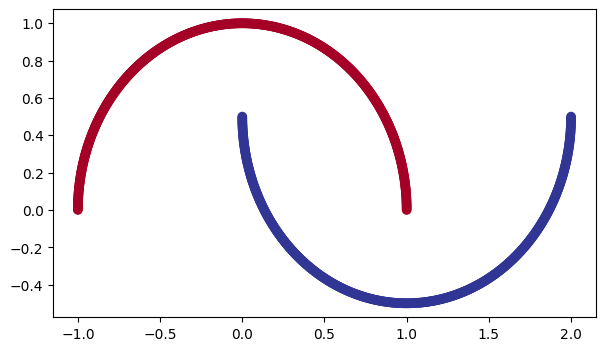

In [85]:
plt.figure(figsize=(7, 4))
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.RdYlBu)

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
class patrickNeuralNetwork(nn.Module):
    def __init__(self,n_features,output_features,hidden_units=8) :
        super().__init__()
        self.linearStack = nn.Sequential(
            nn.Linear(in_features=n_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    
    def forward(self,x):
        return self.linearStack(x)

In [88]:
model = patrickNeuralNetwork(NUM_FEATURES,output_features=1).to(device)
model

patrickNeuralNetwork(
  (linearStack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [89]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [90]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [91]:
print(y_data)

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 

In [92]:
from torchmetrics import Accuracy

torch.manual_seed(RANDOM_SEED)
#torch.seed(RANDOM_SEED)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
Acc = Accuracy(task="binary")
for epoch in range(epochs):

    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #quand on utilise une loss fonction BCEwithLogitsLoss, on passe les logits en comparaison
    loss = loss_fn(y_logits,y_train)

    acc = Acc(y_train,y_pred)
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = Acc(y_test,test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70254, Acc: 0.50% | Test Loss: 0.69781, Test Acc: 0.50%
Epoch: 10 | Loss: 0.66220, Acc: 0.72% | Test Loss: 0.66050, Test Acc: 0.69%
Epoch: 20 | Loss: 0.56928, Acc: 0.79% | Test Loss: 0.57184, Test Acc: 0.76%
Epoch: 30 | Loss: 0.43366, Acc: 0.81% | Test Loss: 0.44159, Test Acc: 0.80%
Epoch: 40 | Loss: 0.30774, Acc: 0.86% | Test Loss: 0.30700, Test Acc: 0.85%
Epoch: 50 | Loss: 0.23427, Acc: 0.89% | Test Loss: 0.23368, Test Acc: 0.90%
Epoch: 60 | Loss: 0.20902, Acc: 0.90% | Test Loss: 0.19990, Test Acc: 0.92%
Epoch: 70 | Loss: 0.18585, Acc: 0.91% | Test Loss: 0.18057, Test Acc: 0.93%
Epoch: 80 | Loss: 0.15221, Acc: 0.93% | Test Loss: 0.14190, Test Acc: 0.94%
Epoch: 90 | Loss: 0.09879, Acc: 0.97% | Test Loss: 0.08309, Test Acc: 0.98%


In [96]:
data = {361066: {8: ('classification', 0.7617396785376616), 20: ('classification', 0.7670973841790104), 50: ('classification', 0.7658367475575165), 100: ('classification', 0.7630003151591553), 180: ('classification', 0.7642609517806492), 200: ('classification', 0.7295934446895682)}, 361076: {8: ('regression', 0.7306415), 20: ('regression', 0.7323228), 50: ('regression', 0.7366748), 100: ('regression', 0.7393718), 180: ('regression', 0.74325174), 200: ('regression', 0.75782114)}, 361085: {8: ('regression', 0.04658459111295309), 20: ('regression', 0.04509640814057335), 50: ('regression', 0.04940557568445352), 100: ('regression', 0.047847488398478216), 180: ('regression', 0.04854184062137413), 200: ('regression', 0.05001452633494936)}, 361088: {8: ('regression', 13.6638459103719), 20: ('regression', 14.196785975932952), 50: ('regression', 14.778095502340939), 100: ('regression', 15.144033906155393), 180: ('regression', 15.445019918673523), 200: ('regression', 16.01074518854403)}, 361089: {8: ('regression', 0.2509209022474643), 20: ('regression', 0.24841141236436243), 50: ('regression', 0.25085037782143976), 100: ('regression', 0.24395926041547616), 180: ('regression', 0.24342003006942206), 200: ('regression', 0.24434967451282638)}, 361110: {8: ('classification', 0.7688442211055276), 20: ('classification', 0.7685843008144169), 50: ('classification', 0.7634725350892393), 100: ('classification', 0.7492635591751863), 180: ('classification', 0.7575810084907295), 200: ('classification', 0.7425922717033443)}, 361111: {8: ('classification', 0.551270815074496), 20: ('classification', 0.535056967572305), 50: ('classification', 0.5560911481156879), 100: ('classification', 0.5683610867659947), 180: ('classification', 0.537248028045574), 200: ('classification', 0.5416301489921121)}, 361112: {8: ('classification', 0.7456953642384105), 20: ('classification', 0.7245033112582782), 50: ('classification', 0.7278145695364239), 100: ('classification', 0.7311258278145696), 180: ('classification', 0.7178807947019867), 200: ('classification', 0.7092715231788079)}, 361114: {8: ('classification', 0.6391683433936955), 20: ('classification', 0.6096579476861167), 50: ('classification', 0.6398390342052314), 100: ('classification', 0.613682092555332), 180: ('classification', 0.6042924211938296), 200: ('classification', 0.6049631120053656)}, 361116: {8: ('classification', 0.6843581013418786), 20: ('classification', 0.6639295013018226), 50: ('classification', 0.6701381934708592), 100: ('classification', 0.6431003404766673), 180: ('classification', 0.6368916483076307), 200: ('classification', 0.607450430602844)}, 361099: {8: ('regression', 115.25619442923029), 20: ('regression', 115.29041452104958), 50: ('regression', 115.66978709909198), 100: ('regression', 117.07590066432115), 180: ('regression', 117.0340408440459), 200: ('regression', 118.95057888927539)}, 361102: {8: ('regression', 0.2719617793725434), 20: ('regression', 0.2670074179422034), 50: ('regression', 0.27807784048015866), 100: ('regression', 0.27455031718864176), 180: ('regression', 0.28152496852442505), 200: ('regression', 0.3145449846655261)}}
data[361099]

{8: ('regression', 115.25619442923029),
 20: ('regression', 115.29041452104958),
 50: ('regression', 115.66978709909198),
 100: ('regression', 117.07590066432115),
 180: ('regression', 117.0340408440459),
 200: ('regression', 118.95057888927539)}

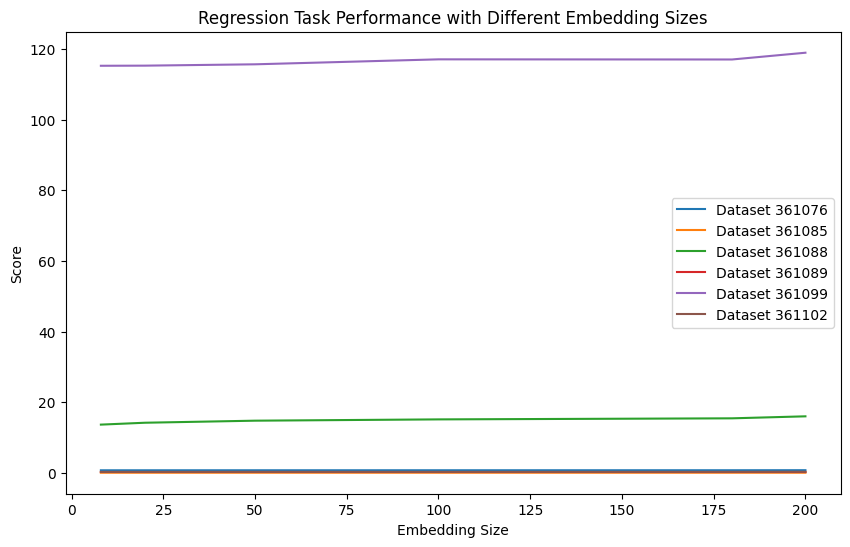

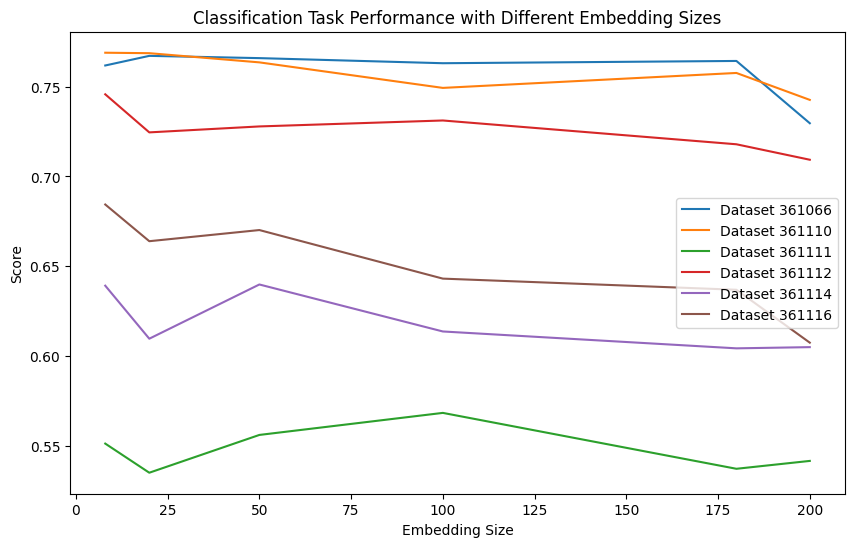

In [95]:
import matplotlib.pyplot as plt

results_emb = {361066: {8: ('classification', 0.7617396785376616), 20: ('classification', 0.7670973841790104), 50: ('classification', 0.7658367475575165), 100: ('classification', 0.7630003151591553), 180: ('classification', 0.7642609517806492), 200: ('classification', 0.7295934446895682)}, 361076: {8: ('regression', 0.7306415), 20: ('regression', 0.7323228), 50: ('regression', 0.7366748), 100: ('regression', 0.7393718), 180: ('regression', 0.74325174), 200: ('regression', 0.75782114)}, 361085: {8: ('regression', 0.04658459111295309), 20: ('regression', 0.04509640814057335), 50: ('regression', 0.04940557568445352), 100: ('regression', 0.047847488398478216), 180: ('regression', 0.04854184062137413), 200: ('regression', 0.05001452633494936)}, 361088: {8: ('regression', 13.6638459103719), 20: ('regression', 14.196785975932952), 50: ('regression', 14.778095502340939), 100: ('regression', 15.144033906155393), 180: ('regression', 15.445019918673523), 200: ('regression', 16.01074518854403)}, 361089: {8: ('regression', 0.2509209022474643), 20: ('regression', 0.24841141236436243), 50: ('regression', 0.25085037782143976), 100: ('regression', 0.24395926041547616), 180: ('regression', 0.24342003006942206), 200: ('regression', 0.24434967451282638)}, 361110: {8: ('classification', 0.7688442211055276), 20: ('classification', 0.7685843008144169), 50: ('classification', 0.7634725350892393), 100: ('classification', 0.7492635591751863), 180: ('classification', 0.7575810084907295), 200: ('classification', 0.7425922717033443)}, 361111: {8: ('classification', 0.551270815074496), 20: ('classification', 0.535056967572305), 50: ('classification', 0.5560911481156879), 100: ('classification', 0.5683610867659947), 180: ('classification', 0.537248028045574), 200: ('classification', 0.5416301489921121)}, 361112: {8: ('classification', 0.7456953642384105), 20: ('classification', 0.7245033112582782), 50: ('classification', 0.7278145695364239), 100: ('classification', 0.7311258278145696), 180: ('classification', 0.7178807947019867), 200: ('classification', 0.7092715231788079)}, 361114: {8: ('classification', 0.6391683433936955), 20: ('classification', 0.6096579476861167), 50: ('classification', 0.6398390342052314), 100: ('classification', 0.613682092555332), 180: ('classification', 0.6042924211938296), 200: ('classification', 0.6049631120053656)}, 361116: {8: ('classification', 0.6843581013418786), 20: ('classification', 0.6639295013018226), 50: ('classification', 0.6701381934708592), 100: ('classification', 0.6431003404766673), 180: ('classification', 0.6368916483076307), 200: ('classification', 0.607450430602844)}, 361099: {8: ('regression', 115.25619442923029), 20: ('regression', 115.29041452104958), 50: ('regression', 115.66978709909198), 100: ('regression', 117.07590066432115), 180: ('regression', 117.0340408440459), 200: ('regression', 118.95057888927539)}, 361102: {8: ('regression', 0.2719617793725434), 20: ('regression', 0.2670074179422034), 50: ('regression', 0.27807784048015866), 100: ('regression', 0.27455031718864176), 180: ('regression', 0.28152496852442505), 200: ('regression', 0.3145449846655261)}}

# Separate data for regression and classification tasks
regression_data = {k: v for k, v in results_emb.items() if v[list(v.keys())[0]][0] == 'regression'}
classification_data = {k: v for k, v in results_emb.items() if v[list(v.keys())[0]][0] == 'classification'}

# Plot for regression task
plt.figure(figsize=(10, 6))
for key, values in regression_data.items():
    embedding_sizes = list(values.keys())
    scores = [value[1] for value in values.values()]
    plt.plot(embedding_sizes, scores, label=f"Dataset {key}")
plt.title("Regression Task Performance with Different Embedding Sizes")
plt.xlabel("Embedding Size")
plt.ylabel("Score")
plt.legend()
plt.show()

# Plot for classification task
plt.figure(figsize=(10, 6))
for key, values in classification_data.items():
    embedding_sizes = list(values.keys())
    scores = [value[1] for value in values.values()]
    plt.plot(embedding_sizes, scores, label=f"Dataset {key}")
plt.title("Classification Task Performance with Different Embedding Sizes")
plt.xlabel("Embedding Size")
plt.ylabel("Score")
plt.legend()
plt.show()

In [98]:
results_method = {361066: {'baseline': ('classification', 0.7630003151591553), 'feature2vec': ('classification', 0.7595335644500473)}, 361076: {'baseline': ('regression', 0.7419009), 'feature2vec': ('regression', 0.7349161)}, 361085: {'baseline': ('regression', 0.043436570968621926), 'feature2vec': ('regression', 0.04354525223519605)}, 361088: {'baseline': ('regression', 13.401820589628775), 'feature2vec': ('regression', 13.99721351901427)}, 361089: {'baseline': ('regression', 0.24042821113501636), 'feature2vec': ('regression', 0.24049073429459694)}, 361110: {'baseline': ('classification', 0.7697972621729336), 'feature2vec': ('classification', 0.7654652573210882)}, 361111: {'baseline': ('classification', 0.563102541630149), 'feature2vec': ('classification', 0.5574057843996494)}, 361112: {'baseline': ('classification', 0.7251655629139073), 'feature2vec': ('classification', 0.7350993377483444)}, 361114: {'baseline': ('classification', 0.6183769282360831), 'feature2vec': ('classification', 0.5989268947015426)}, 361116: {'baseline': ('classification', 0.6907670739034648), 'feature2vec': ('classification', 0.6561185659923894)}, 361099: {'baseline': ('regression', 115.27739326119277), 'feature2vec': ('regression', 115.35448524145774)}, 361102: {'baseline': ('regression', 0.3501796944468899), 'feature2vec': ('regression', 0.2829220516308869)}}

# Separate data for regression and classification tasks
regression_data = {k: v for k, v in results_method.items() if v[list(v.keys())[0]][0] == 'regression'}
classification_data = {k: v for k, v in results_method.items() if v[list(v.keys())[0]][0] == 'classification'}

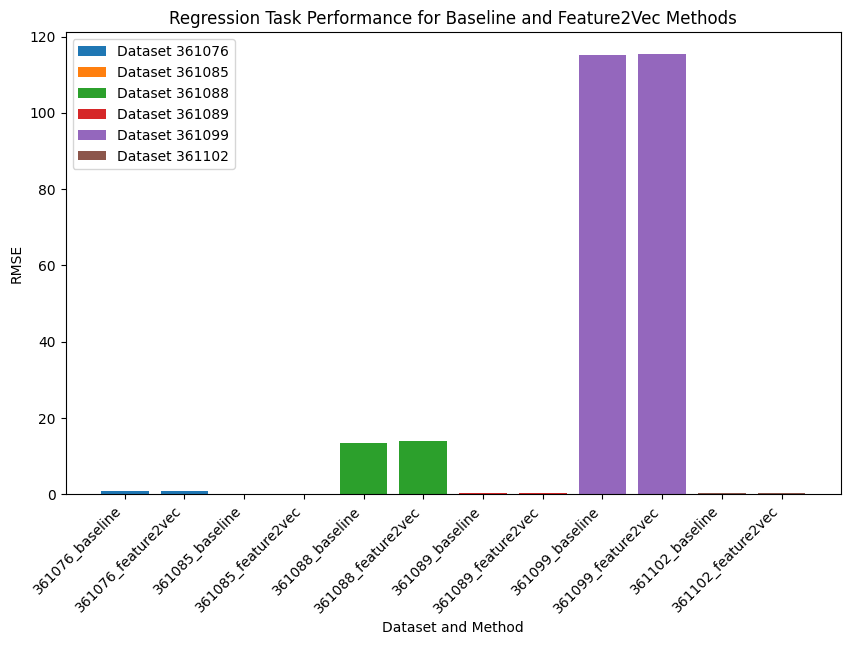

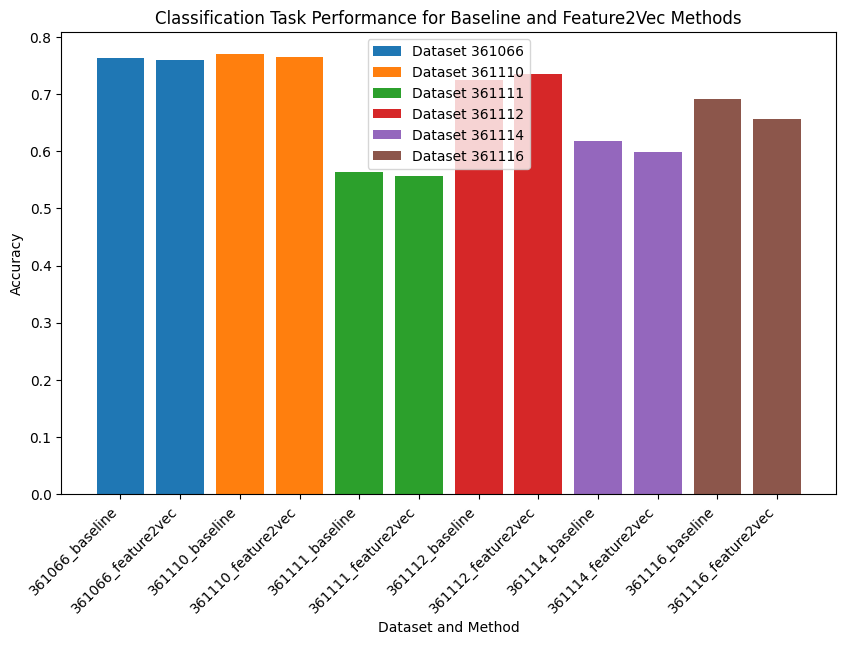

In [100]:
# Plot for regression task
plt.figure(figsize=(10, 6))
for dataset, data in regression_data.items():
    methods = list(data.keys())
    scores = [value[1] for value in data.values()]
    plt.bar([f"{dataset}_{method}" for method in methods], scores, label=f"Dataset {dataset}")
plt.title("Regression Task Performance for Baseline and Feature2Vec Methods")
plt.xlabel("Dataset and Method")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# Plot for classification task
plt.figure(figsize=(10, 6))
for dataset, data in classification_data.items():
    methods = list(data.keys())
    scores = [value[1] for value in data.values()]
    plt.bar([f"{dataset}_{method}" for method in methods], scores, label=f"Dataset {dataset}")
plt.title("Classification Task Performance for Baseline and Feature2Vec Methods")
plt.xlabel("Dataset and Method")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()